<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

##### 7th exercise: <font color="#C70039">Work with Variational Autoencoders (Generative Model)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Student: Nicolas Rehbach
* Matriculation Number: 11133387
* Date:   09.11.2022

<img src="https://miro.medium.com/max/848/1*6uuK7GpIbfTb-0chqFwXXw.png" style="float: center;" width="400">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
A Variational Autoencoder (VAE), instead of compressing its input image into a fixed code in the latent space (as the classic autoencoder does), turns the input image into the parameters of a statistical distribution: a mean and a variance.

This implies / imputes that the input image has been generated by a statistical process and that the randomness of this process should be taken into accounting during encoding and decoding. 

The VAE then uses the mean and variance parameters to randomly sample one element of that distribution, and decodes that element back to the original input. 

The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.


---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
    * try to understand each single step.
4. the notebooks code, especially keras is sometimes utilized a bit cumbersome. Try to optimize the code where you feel necessary.
5. experiment with different hyperparameters (search for the keyword 'task')
6. describe the three different loss curve plots. What do they show? Is this what you expected?
7. the main task is to visualize the latent space, the encoder has created. If you set high dimensions for the latent dim you can use T_SNE (plot 4).
8. describe the latent space with respect to its structure. Is this what you expected from a VAE?
---------------------------------

### VAEs
This code demonstrates a VAE using the MNIST dataset.
Just like a regular autoencoder a VAE returns an array (image) of same dimensions as the input but variation can be introduced by tweaking the so-called latent vector.


### Personal understanding: [`link`](https://www.youtube.com/watch?v=YV9D3TWY5Zo)

- Our pictures are described by a latent distribution. Therefore, each picture has its own vector describing exactly this picture.
- Sampling at the correct position gives us the correct picture. 
- Sampling at the incorrect position (garbage in garbage out) we will get nothing
- Constrain the latent vector values to a specific continuous region
  - As long as we are in the continuous region, we will get a variation of the picture (e.g.: MNIST numbers in different writing styles)
- How to define the latent space?
  - Instead of mapping it to a fixed vector, we map it to a distribution
  - We force the latent variables to be normally distributed
  - We do not pass the whole encoder output to the decoder, but the mean and standard deviation describing the distribution
  - Quantify the distance between learned distribution and the standard normalized distribution by using Kullback-Leibler divergence
  - While we are training, a normal distribution is forced as close as possible to the standard normal distribution using KL as the loss function
  - However, there are 2 parts of the loss function!
    - KL-loss
    - Reconstruction loss
    - both are being minimized
    - Loss function = reconstruction loss + KL divergence loss

Summarizing [`link`](https://wr.informatik.uni-hamburg.de/_media/teaching/sommersemester_2021/siw-21-variational_autoencoder-cindy.pdf):

A VAE is a autoencoder but we are not using a fixed vector but a distribution defined by a mean and std. deviation. From this we are getting a sampled latent vector. VAEs are generally similar to autoencoders with a different bottleneck
- Autoencoder -> only latent vector, VAE -> three vectors
	- Mean vector, standard deviation vector and sampled latent vector
    
We are creating a constrained space of latent vectors which mean something, from which we can sample. Thats why VAE can be used for generative tasks but not normal AE
- In VAEs we arent working with concrete values but with a probability distribution
	- build by the information of the input data

- Regularization -> the probability distribution shall be as close to the standard deviation
	- Without regularization we could create noise as output
- We can not use the sampled latent vector for backprob
	- Therefore we use a reparameterization trick
- We pass a vector epsilon which has random numbers between -1 and 1. This will be multiplied to the std deviation vector sigma and the mean vector mu
    - Why epsilon? The mean and the std deviation are fixed for a specific input. By introducing the epsilon, which is a little bit of noise, we can now sample "unseen" examples. 
- Without the reparameterization trick the mean and standard vector are deterministic while the latent vector is random. By introducing epsilon, also the latent vector is now deterministic and we can apply backprop
During the training, the mean and the standard deviation is trained. The epsilon is sampled by not learned.

$z = \mu + \sigma * \epsilon$ (mean + std. deviation * standard normal distribution (a fixed space but randomly sampled))
- Without our epsilon, the vae would not be able to generate new samples!

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers, models, losses, metrics, optimizers
from   tensorflow.keras.datasets import mnist
import pandas as pd
from sklearn.manifold import TSNE

### Model: "Encoder"
Create an encoder model with the following properties:


In [130]:
# _____________________________________________________________________________
#  Layer (type)                 Output Shape         Activation     Input      
# =============================================================================
#  encoder_input (InputLayer)       [(None, 28, 28, 1)]  None           
#  encoder_flatten (Flatten)        (None, 784)          None           enc_input
#  encoder_dense_1 (Dense)          (None, 2000)         ReLU           enc_flatten
#  encoder_dense_2 (Dense)          (None, 256)          ReLU           enc_dense_1
#  z_mean (Dense)                   (None, 2)            None           enc_dense_2
#  z_log_var (Dense)                (None, 2)            None           enc_dense_2

#Basic encoder architecture
encoder_input = layers.Input(shape=(28,28,1), dtype='float32')
# use a flatten layer (reduce dimensions to 1)
encoder_flatten = layers.Flatten(name = 'flat')(encoder_input)
encoder_dense_1 = layers.Dense(units = 2000, activation = 'relu', name = 'dense_1')(encoder_flatten)
encoder_dense_2 = layers.Dense(units = 256, activation = 'relu', name = 'dense_2')(encoder_dense_1)

# define our z as Dense layer
# finally we define a latent mean layer and latent log varation layer
z_mean = layers.Dense(units = 2, name = 'latent_mean')(encoder_dense_2)
z_log_var  = layers.Dense(units = 2, name = 'latent_log_var')(encoder_dense_2)

encoder = models.Model(inputs = encoder_input, outputs = (z_mean, z_log_var), name = 'encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flat (Flatten)                 (None, 784)          0           ['input_37[0][0]']               
                                                                                                  
 dense_1 (Dense)                (None, 2000)         1570000     ['flat[0][0]']                   
                                                                                                  
 dense_2 (Dense)                (None, 256)          512256      ['dense_1[0][0]']                
                                                                                            

### Model: "decoder"
Create a decoder model with the following properties:

In [131]:
# _____________________________________________________________________________
#  Layer (type)                Output Shape          Activation     Input
# =============================================================================
#  decoder_input (InputLayer)      [(None, 2)]           None
#  decoder_dense_1 (Dense)         (None, 256)           ReLU           dec_input
#  decoder_dense_2 (Dense)         (None, 2000)          ReLU           dec_dense_1
#  decoder_dense_3 (Dense)         (None, 784)           Sigmoid        dec_dense_2
#  img_out (Reshape)               (None, 28, 28, 1)     None           des_dense_3

# after the encoder, we now define a decoder model
# this has three hidden layers 
# Why do we use sigmoid as final activation function?

decoder_input = layers.Input(shape=(2,), dtype='float32')
decoder_dense_1 = layers.Dense(units = 256, activation = 'relu', name = 'dec_dense_1')(decoder_input)
decoder_dense_2 = layers.Dense(units = 2000, activation = 'relu', name = 'dec_dense_2')(decoder_dense_1)
decoder_dense_3 = layers.Dense(units = 784, activation = 'sigmoid', name = 'dec_dense_3')(decoder_dense_2)
img_out = layers.Reshape((28,28,1), name = 'img_out')(decoder_dense_3)

decoder = models.Model(inputs = decoder_input, outputs = img_out, name = 'decoder')
decoder.summary()

# The img_out has the same shape as the input

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 2)]               0         
                                                                 
 dec_dense_1 (Dense)         (None, 256)               768       
                                                                 
 dec_dense_2 (Dense)         (None, 2000)              514000    
                                                                 
 dec_dense_3 (Dense)         (None, 784)               1568784   
                                                                 
 img_out (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 2,083,552
Trainable params: 2,083,552
Non-trainable params: 0
_________________________________________________________________


In [132]:
# class 'latent_sampling', which subclasses layers.Layer.
# The class should perform the reparameterisation trick in its .call() method.

'''---------------------------------------------------------------------------'''
# Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
# epsilon = N(0,1), a unit normal with same dims as mean and variance
'''---------------------------------------------------------------------------'''
class latent_sampling(layers.Layer):
    
    def call(self, z_mean, z_log_var):
        tf.keras.layers.Layer(trainable = True)
        # we take a batch of the shape of z_mean's first element
        self.batch = tf.shape(z_mean)[0]
        # the dimension is defined as z_mean's second element
        self.dim = tf.shape(z_mean)[1]
        # our epsilon is a random tensor of shape self.batch and self dim
        self.epsilon = tf.keras.backend.random_normal(shape=(self.batch, self.dim))
        # we compute our z which is the z_mean + epsilon * our z_log_var (input) * 0.5
        self.z =  z_mean + self.epsilon * tf.exp(z_log_var * 0.5)
        return self.z

# our z is the latent vector, which is now used in the decoding phase

In [133]:
### The 'VAE' Class. 
### The __init__ method—which will set up the layers and submodels—and the call() method.

class VAE(tf.keras.Model):
    """
    A Keras Model that implements a Variational Autoencoder. Model properties
    should include the encoder and decoder models, a sampling layer, and the
    number of latent variables in the encoded space.
    """
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        """
        Take in model properties and assign them to self.
        """
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.sampling = latent_sampling()
        self.decoder = decoder
        
    def encode(self, x):
        """
        Method that applies the encoder model to input data. Returns the mean
        and ln(variance) of the encoded variables.
        """
        #encoder = models.Model(inputs = encoder_input, outputs = (z_mean, z_log_var), name = 'encoder')
        mean, logvar = self.encoder(x)
        return mean, logvar

    def decode(self, z):
        """
        Method that applies the decoder model to a set of encoded variables.
        Returns the generated images from the encoded data.
        """
        # decoder = models.Model(inputs = decoder_input, outputs = img_out, name = 'decoder')
        x_hat = self.decoder(z)
        return x_hat

    def kl_loss(self, mean, logvar):
        """
        Method that calculates the Kullback-Liebler divergence between the
        posterier distribution, N(mean, variance), and the prior, N(0,1).
        Can be added to the model as a loss or metric, using self.add_loss and
        self.add_metric
        """

        # Calculate the element wise KL divergence
        kl = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        # Sum up the divergence of all the variables in each data sample
        kl = tf.reduce_sum(kl, axis=1)
        # Average the divergence across all samples in the batch
        kl = tf.reduce_mean(kl)
        return kl

    def call(self, inputs):
        """
        Apply the encoder, sampling layer and decoder to the input data. Add
        the kl divergence to the model losses and metrics. Return the generated
        image.
        """
        z_mean, z_log_var = self.encoder(inputs)
        sampled_output = self.sampling(z_mean, z_log_var)
        output = self.decoder(sampled_output)
        self.add_loss(self.kl_loss(z_mean, z_log_var))
        self.add_metric(self.kl_loss(z_mean, z_log_var), name = 'kl_loss_metric')
        return output

        # Here we added our latent vector z to the encoder as inputs
        # Then we are sampling with our vectors and add he KL loss

In [134]:
# Modified loss function for the model. The standard binary cross entropy
# takes a mean over all pixels in all images, but the VAE needs the
# reconstruction loss to be the sum of the pixel-wise losses, averaged over
# samples in the batch. Otherwise the reconstruction loss is becoming too small.

#Since we have the KL loss and the reconstruction loss in vaes, both have to be defined

def recon_loss(y_true, y_pred):
    loss = tf.reduce_sum(losses.binary_crossentropy(y_true, y_pred),axis=(1, 2))
    return loss

In [135]:
# Create the VAE model, using your encoder and decoder models. 
# Compile the model with appropriate optimizer settings, losses and metrics.
'''
(TASK: don't be afraid to experiment with different settings here (e.g. latent_dim))
'''

# Our VAE consists of a latent dimension of 2, the encoder and decoder
autoencoder = VAE(latent_dim = 2, encoder = encoder, decoder = decoder)

# Default learning rate, optimizer = nAdam.
autoencoder.compile(tf.keras.optimizers.Nadam(),loss = recon_loss,
                    metrics = [recon_loss, 'accuracy'])

In [136]:
# Load the MNIST data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Function to preprocess the data 
def preprocessing(image):
    image =  tf.expand_dims(image, -1)
    image =  tf.image.random_flip_left_right(image)
    image  = tf.image.convert_image_dtype(image, 'float32')

    return image, image

# Slice off the training data
dataset = tf.data.Dataset.from_tensor_slices(x_train)

# Preparing the data for training 
final_dataset = dataset.shuffle(1000).batch(64, drop_remainder=True).map(preprocessing)

### Train the model
Train the model on the images from the training set until the losses converge.
"history = model.fit" allows for storing the training and validation losses in a dictionary so they can be visualized later.

In [138]:
history = autoencoder.fit(final_dataset, batch_size = 256, epochs =30)
history.history.keys()  

Epoch 1/30
937/937 [==============================] - 19s 21ms/step - loss: 172.3061 - recon_loss: 167.6915 - accuracy: 0.7934 - kl_loss_metric: 4.6146
Epoch 2/30
937/937 [==============================] - 19s 21ms/step - loss: 164.2213 - recon_loss: 158.9814 - accuracy: 0.7943 - kl_loss_metric: 5.2399
Epoch 3/30
937/937 [==============================] - 19s 21ms/step - loss: 161.2928 - recon_loss: 155.8110 - accuracy: 0.7943 - kl_loss_metric: 5.4819
Epoch 4/30
937/937 [==============================] - 19s 20ms/step - loss: 159.5424 - recon_loss: 153.8960 - accuracy: 0.7946 - kl_loss_metric: 5.6463
Epoch 5/30
937/937 [==============================] - 19s 20ms/step - loss: 157.8983 - recon_loss: 152.0943 - accuracy: 0.7950 - kl_loss_metric: 5.8040
Epoch 6/30
937/937 [==============================] - 19s 21ms/step - loss: 156.5632 - recon_loss: 150.6040 - accuracy: 0.7955 - kl_loss_metric: 5.9591
Epoch 7/30
937/937 [==============================] - 20s 21ms/step - loss: 155.2824 - r

dict_keys(['loss', 'recon_loss', 'accuracy', 'kl_loss_metric'])

In [139]:
#print(history.history['loss'], history.history['recon_loss'])
diff_loss = np.array(history.history['loss']) - np.array(history.history['recon_loss'])
kl_loss = history.history['kl_loss_metric']

print(diff_loss, kl_loss)

[4.61456299 5.23995972 5.48176575 5.64640808 5.80400085 5.95918274
 6.10684204 6.24000549 6.33332825 6.42007446 6.48861694 6.55171204
 6.56376648 6.6366272  6.68092346 6.72047424 6.74743652 6.77445984
 6.81181335 6.81619263 6.8631897  6.88348389 6.89263916 6.91081238
 6.93760681 6.96975708 6.96794128 6.98728943 7.00718689 7.00723267] [4.614566326141357, 5.239871025085449, 5.48190450668335, 5.6463422775268555, 5.804012298583984, 5.959084987640381, 6.1069135665893555, 6.239945888519287, 6.3333306312561035, 6.420065402984619, 6.488546371459961, 6.5517072677612305, 6.563776016235352, 6.636634826660156, 6.680798530578613, 6.7204694747924805, 6.747348785400391, 6.7744269371032715, 6.811822891235352, 6.816198348999023, 6.863039493560791, 6.8835320472717285, 6.892519950866699, 6.910768508911133, 6.937609672546387, 6.969714641571045, 6.967869281768799, 6.987323760986328, 7.007178783416748, 7.007236480712891]


In [140]:
from keras.models import load_model

#autoencoder.save('./latent_dim10_100epochs')
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

### Visualize the results (plot 1)
Create plots that show the losses and metrics, the reconstruction quality of
the trained network, and the generative quality of the network. 

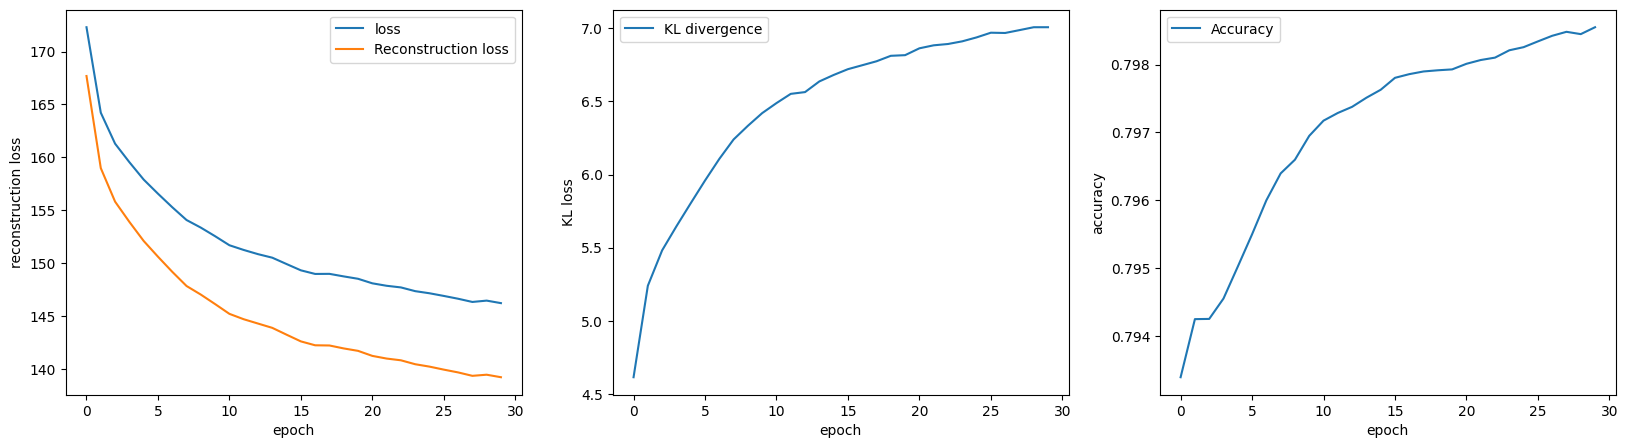

In [141]:
f, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(history.history['loss'], label = 'loss')
ax[0].plot(history.history['recon_loss'], label = 'Reconstruction loss')
ax[0].set_ylabel('reconstruction loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history.history['kl_loss_metric'], label = 'KL divergence')
ax[1].set_ylabel('KL loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].plot(history.history['accuracy'], label = 'Accuracy')
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].legend()

plt.show()

### 5. Experiment with different hyperparameters:

Different hyperparameters were used when training the model. Using a lower amount of epochs like 5, resulted in much blurrier reconstructions. Using 30+ turned out in quite good results. 

### 6. describe the three different loss curve plots. What do they show? Is this what you expected?

- What is loss for the VAE
    - The total loss function is the reconstruction loss + KL divergence loss
- What is reconstruction loss?
    - Measures how close the output (by the decoder) is to the input (original picture)
- What is the KL divergence?
    - statistical distance describing how one probability distribution is different from another
- What is our accuracy?
    - $\frac{TP+TN}{TP+TN+FP+FN}$
    
#### Using a latent dim of 2, 30 epochs:
1st Plot:

We can observe a flattening curve over the 30 epochs. Since the total loss consists of the reconstruction loss + the KL divergence, the total loss is generally higher than our reconstruction loss.

loss: 180 - 150
Reconstruction loss: 175 - 140

2nd Plot:

Similar to the first plot, we can observe a flattening curve. However, the KL-loss is rising. We can observe that while the networks gets better results and minimizes its loss, the KL divergence is rising accordingly.

KL-loss: 4.5 - 7

3rd Plot:

Accuracy: 0.793 - 0.798

Here we can observe our accuracy increasing by a bit from 0.793 to 0.799.

#### Using a latent dim of 5, 30 epochs without hardcoded 2 dimensions:
Similar to the other dimensions however with a smooth increase in KL loss and accuracy which saturates over time.
The prediction of the data is almost identical.

Our two dimensional visualiaztion is now much more constrained. Therefore, this is probably now actual 5 dimensions.

#### Expectations
While the decreasing reconstruction loss and increasing accuracy were expected, the increase in KL-loss surprised me. In a learning session with Jüri and Mark, we discussed, that it could possibly due to to being different kinds of metrics.

While we try to optimize our probability distribution q to be as close to our reference distribution p in the reconstruction loss, the KL divergence measures how "far apart" the distributions are from another. Therefore, a rising KL loss maybe is not negative.


### Prediction of test data (plot 2)

 14/313 [>.............................] - ETA: 1s  

2023-01-15 21:19:29.519708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step


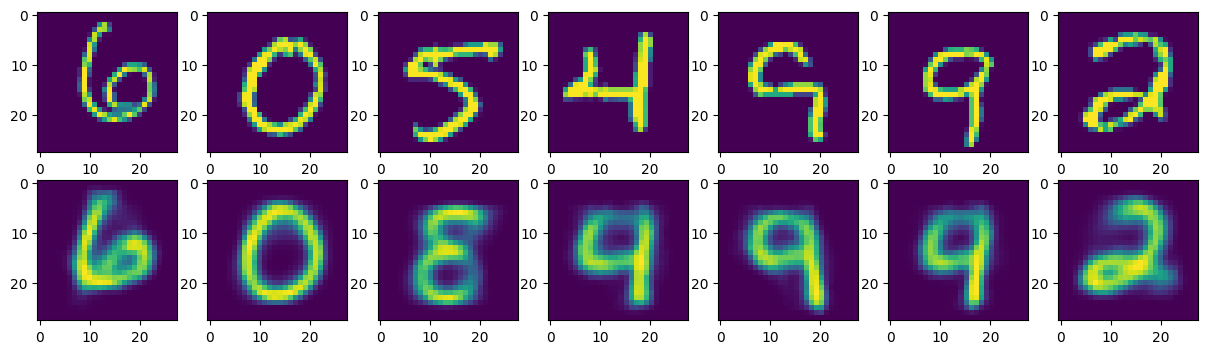

In [142]:
predict = autoencoder.predict(x_test/255.)
f, ax = plt.subplots(2, 7, figsize = (15,4))

# Testing the reconstruction quality of the network using the Test Images 
for i in range(7):
    ax[0,i].imshow(x_test[i+100])
    ax[1,i].imshow(predict[i+100,:,:,0])

### Testing the generative quality of the network (plot 3)

1/1 [==============================] - 0s 12ms/step


2023-01-15 21:19:31.200781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


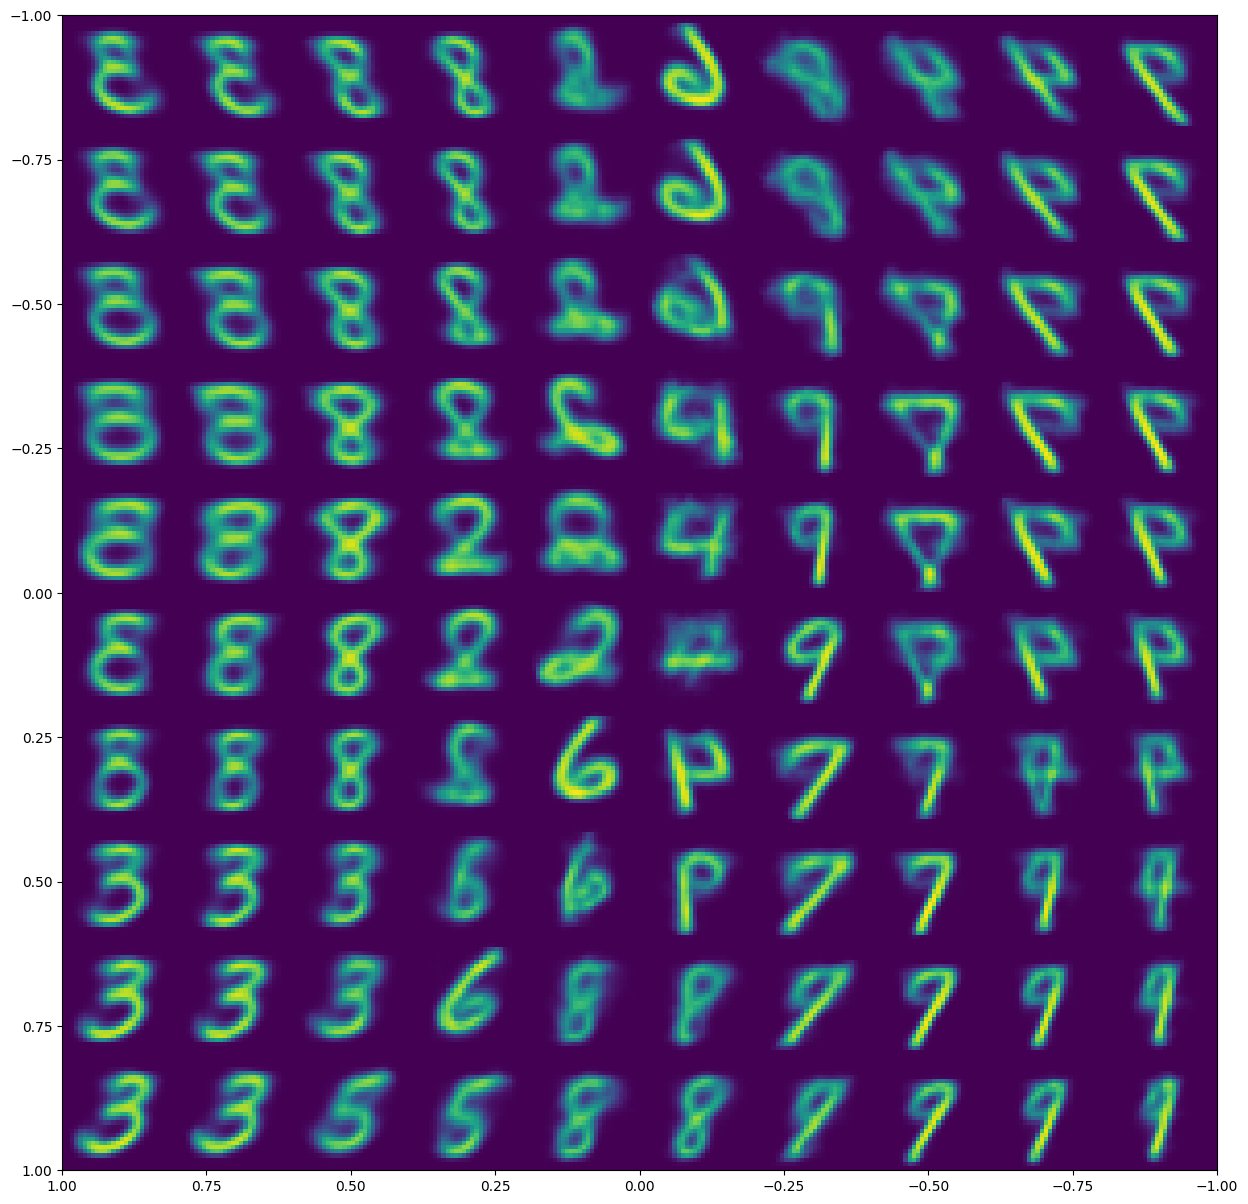

In [143]:
x_axis = np.linspace(-1, 1, 10)
y_axis = np.linspace(-1, 1, 10)
figure = np.zeros((28 * 10, 28 * 10))

# loop through each number for decoding
for i_x, x in enumerate(x_axis):
    for i_y, y in enumerate(y_axis):
        latent = np.array([[x, y]])
        #print(latent)
        generated_image = decoder.predict(latent)[0] # decode the numbers
        figure[i_x*28:(i_x+1)*28, i_y*28:(i_y+1)*28,] = generated_image[:,:,-1]

plt.figure(figsize=(15, 15))
plt.imshow(figure, extent=[1,-1,1,-1])
plt.show()

In [144]:
def prep_z():
    z = encoder.predict(x_test/255.)
    latent_arr = []
    for i in range(len(z[0])):
    #print(i)
        latent_arr.append(z[0][i])

    latent_arr[0]
    latent_df = pd.DataFrame(latent_arr)
    latent_df['number'] = y_test
    return latent_df

In [145]:
def plot_latent(df):
    plt.figure(figsize=(12, 10))
    plt.scatter(x = df[0], y = df[1], c = df['number'])
    plt.colorbar()
    plt.xlabel('dimension 0')
    plt.ylabel('dimension 1')
    plt.title('Latent space of our encoder')
    plt.show()

110/313 [=========>....................] - ETA: 0s

2023-01-15 21:19:34.612597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 1ms/step


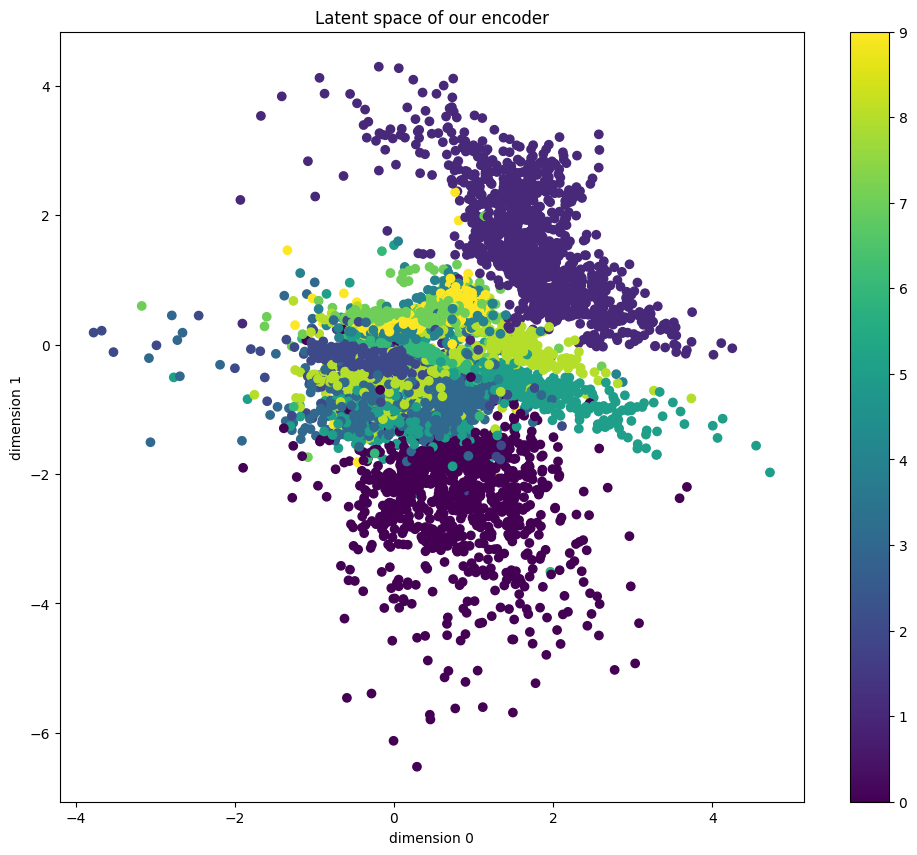

In [146]:
latent_df = prep_z()
plot_latent(latent_df)

### 7. the main task is to visualize the latent space, the encoder has created. If you set high dimensions for the latent dim you can use T_SNE (plot 4).


#### Visualizing using a latent dimension of 2:

## Visualizing latent dim > 2


How does t-SNE work? (https://www.youtube.com/watch?v=NEaUSP4YerM)

- t-SNE takes a higher dimensional dataset and reduces it to a low dimensional graph, which captures a high amount of its information.
- t-SNE starts by positioning the points in 1d in a random order
- then t-SNE moves the point to cluster them
- it seems to works a bit like a sorting algorithm, based on the position in the multidimensional space
    - points are drawn to points that are close to another in the higher dimensional space and pushed away for points that are far away
1. determine the similarity between a point and all other points
2. plot the distance on a standard distribution curve
3. draw a line from the point to the curve, this is the "unscaled similarity"
4. scale the unscaled similarities till they add up to 1
    - less dense regions have a wider curve
    - scaled score = $\frac{score}{sumofallscores}$
5. once calculated for all the points, you end up with a matrix of similarity score


In [100]:
def get_encoder(dimensions):
    #Basic encoder architecture
    encoder_input = layers.Input(shape=(28,28,1), dtype='float32')
    encoder_flatten = layers.Flatten(name = 'flat')(encoder_input)
    encoder_dense_1 = layers.Dense(units = 2000, activation = 'relu', name = 'dense_1')(encoder_flatten)
    encoder_dense_2 = layers.Dense(units = 256, activation = 'relu', name = 'dense_2')(encoder_dense_1)

    # define our z as Dense layer
    # finally we define a latent mean layer and latent log varation layer
    z_mean = layers.Dense(units = dimensions, name = 'latent_mean')(encoder_dense_2)
    z_log_var  = layers.Dense(units = dimensions, name = 'latent_log_var')(encoder_dense_2)

    encoder = models.Model(inputs = encoder_input, outputs = (z_mean, z_log_var), name = 'encoder')
    return encoder

In [101]:
def get_decoder(dimensions):
    decoder_input = layers.Input(shape=(dimensions,), dtype='float32')
    decoder_dense_1 = layers.Dense(units = 256, activation = 'relu', name = 'dec_dense_1')(decoder_input)
    decoder_dense_2 = layers.Dense(units = 2000, activation = 'relu', name = 'dec_dense_2')(decoder_dense_1)
    decoder_dense_3 = layers.Dense(units = 784, activation = 'sigmoid', name = 'dec_dense_3')(decoder_dense_2)
    img_out = layers.Reshape((28,28,1), name = 'img_out')(decoder_dense_3)

    decoder = models.Model(inputs = decoder_input, outputs = img_out, name = 'decoder')
    return decoder

In [104]:
def plot_loss(history):
    f, ax = plt.subplots(1,3, figsize = (20,5))

    ax[0].plot(history.history['loss'], label = 'loss')
    ax[0].plot(history.history['recon_loss'], label = 'Reconstruction loss')
    ax[0].set_ylabel('reconstruction loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    ax[1].plot(history.history['kl_loss_metric'], label = 'KL divergence')
    ax[1].set_ylabel('KL loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend()

    ax[2].plot(history.history['accuracy'], label = 'Accuracy')
    ax[2].set_ylabel('accuracy')
    ax[2].set_xlabel('epoch')
    ax[2].legend()

    plt.show()

Epoch 1/10


2023-01-15 20:37:15.313373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


937/937 [==============================] - 21s 22ms/step - loss: 178.8791 - recon_loss: 173.9710 - accuracy: 0.7929 - kl_loss_metric: 4.9081
Epoch 2/10
937/937 [==============================] - 20s 21ms/step - loss: 165.0696 - recon_loss: 159.7791 - accuracy: 0.7941 - kl_loss_metric: 5.2903
Epoch 3/10
937/937 [==============================] - 20s 21ms/step - loss: 161.6825 - recon_loss: 156.1575 - accuracy: 0.7943 - kl_loss_metric: 5.5250
Epoch 4/10
937/937 [==============================] - 20s 22ms/step - loss: 160.0527 - recon_loss: 154.3904 - accuracy: 0.7943 - kl_loss_metric: 5.6623
Epoch 5/10
937/937 [==============================] - 20s 21ms/step - loss: 158.2581 - recon_loss: 152.4512 - accuracy: 0.7946 - kl_loss_metric: 5.8068
Epoch 6/10
937/937 [==============================] - 20s 21ms/step - loss: 157.0016 - recon_loss: 151.0886 - accuracy: 0.7949 - kl_loss_metric: 5.9129
Epoch 7/10
937/937 [==============================] - 20s 21ms/step - loss: 155.8870 - recon_loss: 

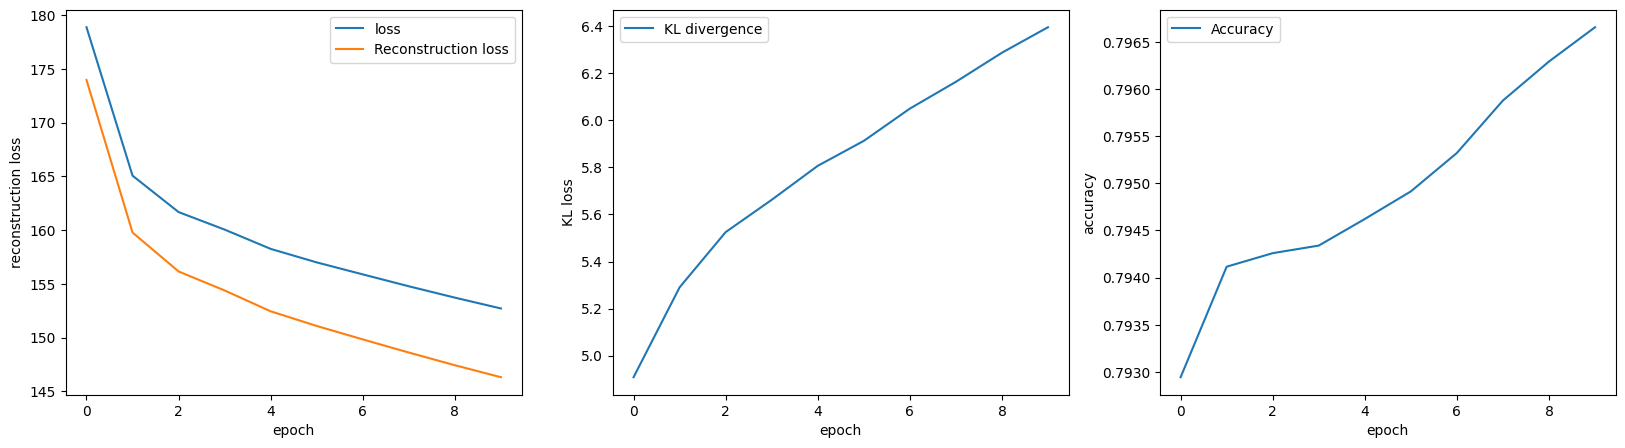

 93/313 [=======>......................] - ETA: 0s

2023-01-15 20:40:39.216769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Plotting a normal 2 Dimensional Plot with  2  latent dimensions:


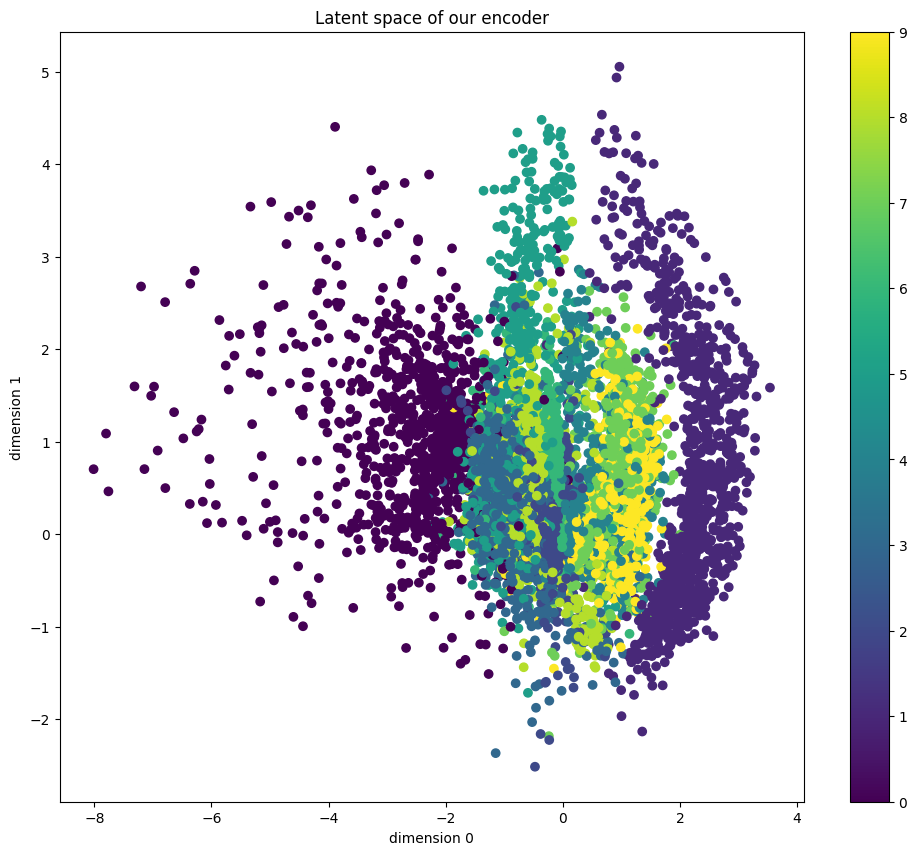

Plotting using T-SNE with 2 latent dimensions:


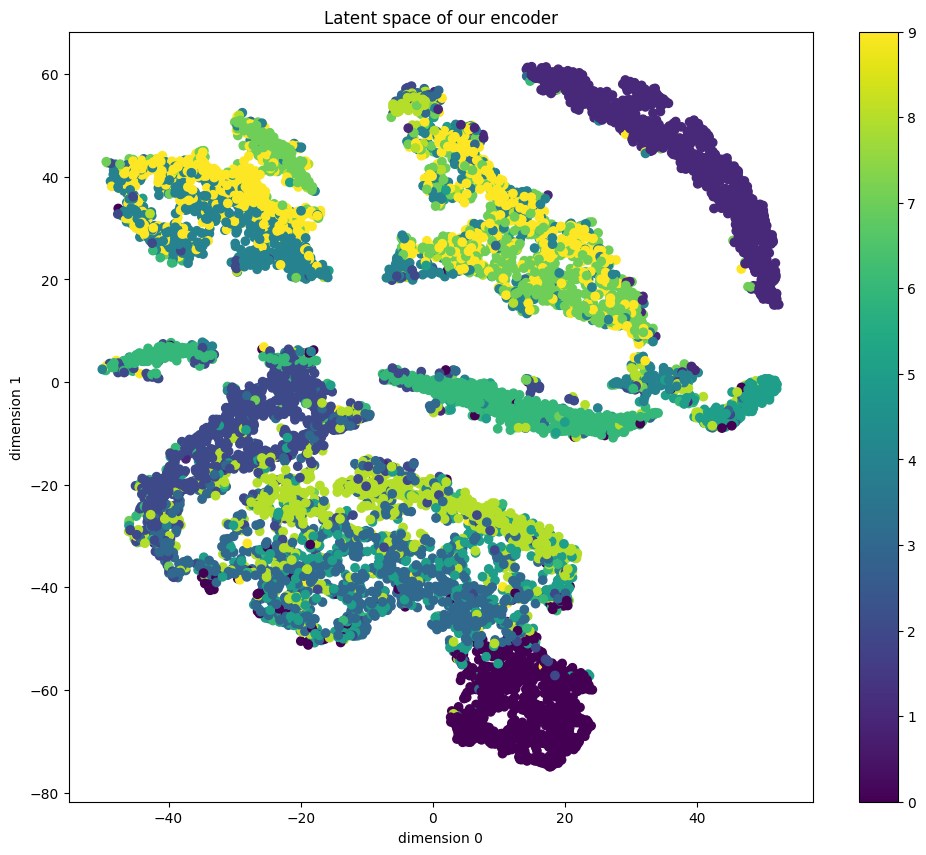

Epoch 1/10


2023-01-15 20:41:24.128057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


937/937 [==============================] - 26s 26ms/step - loss: 161.7508 - recon_loss: 153.6237 - accuracy: 0.7954 - kl_loss_metric: 8.1271
Epoch 2/10
937/937 [==============================] - 24s 26ms/step - loss: 141.9181 - recon_loss: 132.5341 - accuracy: 0.7995 - kl_loss_metric: 9.3841
Epoch 3/10
937/937 [==============================] - 21s 22ms/step - loss: 136.8753 - recon_loss: 127.0739 - accuracy: 0.8007 - kl_loss_metric: 9.8016
Epoch 4/10
937/937 [==============================] - 21s 22ms/step - loss: 134.2426 - recon_loss: 124.2188 - accuracy: 0.8014 - kl_loss_metric: 10.0238
Epoch 5/10
937/937 [==============================] - 20s 22ms/step - loss: 132.2613 - recon_loss: 122.0508 - accuracy: 0.8020 - kl_loss_metric: 10.2105
Epoch 6/10
937/937 [==============================] - 20s 22ms/step - loss: 130.8293 - recon_loss: 120.4546 - accuracy: 0.8024 - kl_loss_metric: 10.3746
Epoch 7/10
937/937 [==============================] - 20s 22ms/step - loss: 129.5156 - recon_los

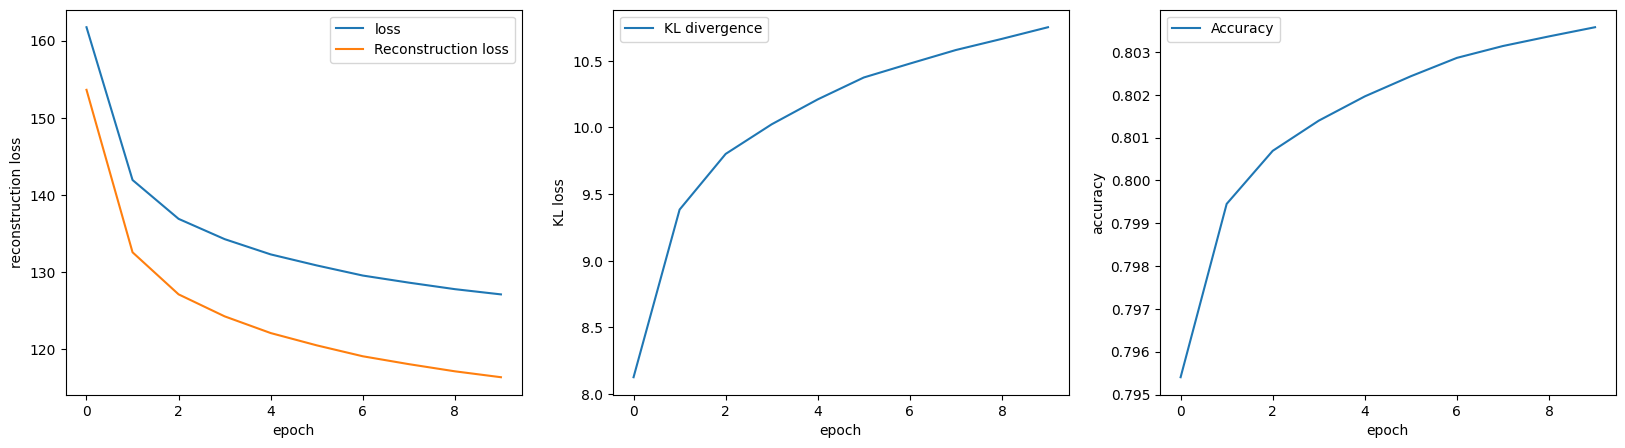

106/313 [=========>....................] - ETA: 0s

2023-01-15 20:44:57.886773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 1ms/step
Plotting a normal 2 Dimensional Plot with  4  latent dimensions:


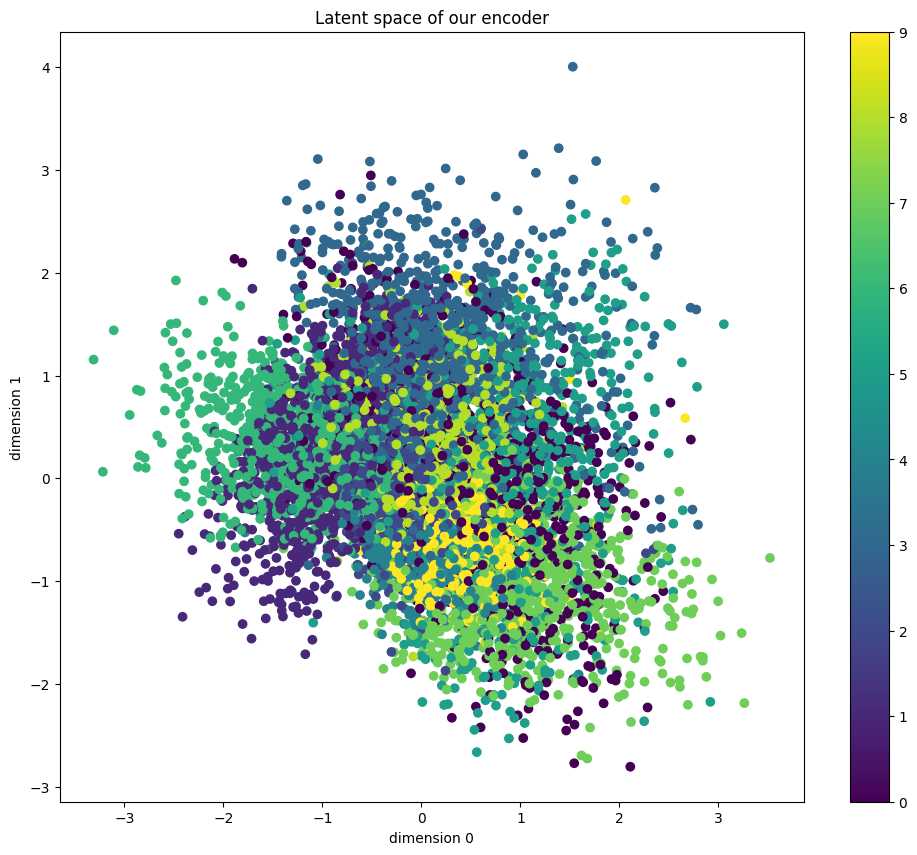

Plotting using T-SNE with 4 latent dimensions:


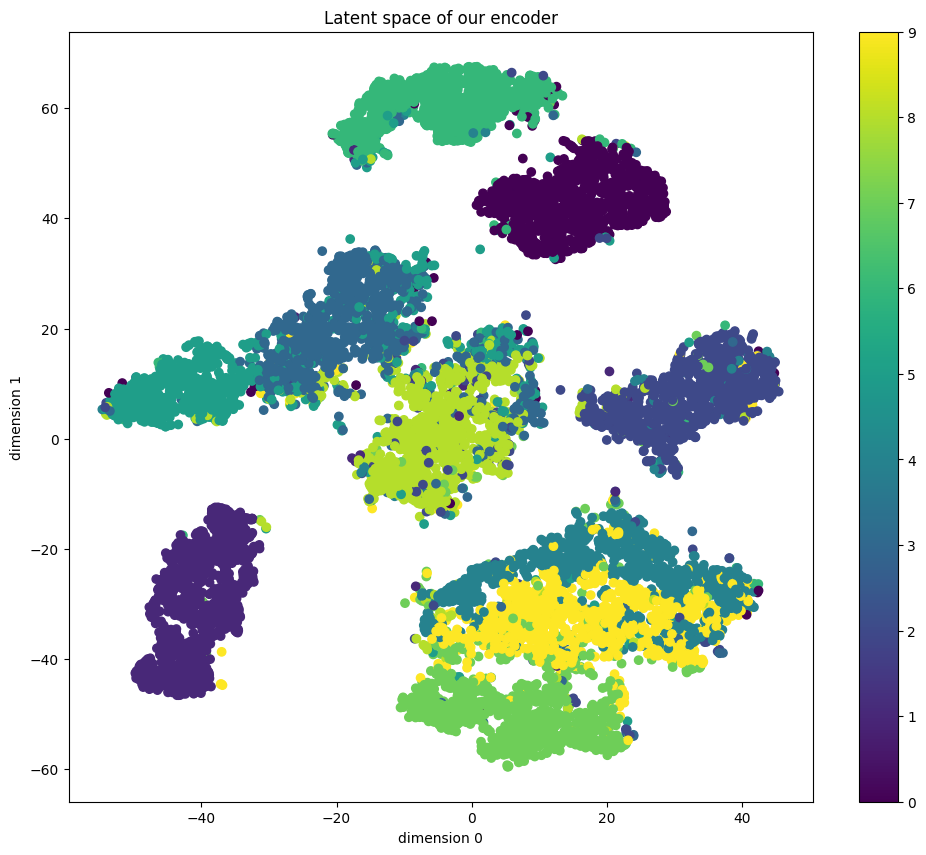

Epoch 1/10


2023-01-15 20:45:38.958658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


937/937 [==============================] - 21s 21ms/step - loss: 150.3136 - recon_loss: 139.5843 - accuracy: 0.7987 - kl_loss_metric: 10.7294
Epoch 2/10
937/937 [==============================] - 20s 21ms/step - loss: 129.6680 - recon_loss: 117.3627 - accuracy: 0.8034 - kl_loss_metric: 12.3052
Epoch 3/10
937/937 [==============================] - 20s 22ms/step - loss: 124.8421 - recon_loss: 112.0334 - accuracy: 0.8047 - kl_loss_metric: 12.8086
Epoch 4/10
937/937 [==============================] - 21s 23ms/step - loss: 121.9520 - recon_loss: 108.8757 - accuracy: 0.8055 - kl_loss_metric: 13.0763
Epoch 5/10
937/937 [==============================] - 23s 24ms/step - loss: 119.9061 - recon_loss: 106.6024 - accuracy: 0.8060 - kl_loss_metric: 13.3037
Epoch 6/10
937/937 [==============================] - 23s 24ms/step - loss: 118.4025 - recon_loss: 104.9432 - accuracy: 0.8065 - kl_loss_metric: 13.4595
Epoch 7/10
937/937 [==============================] - 23s 24ms/step - loss: 117.2199 - recon_

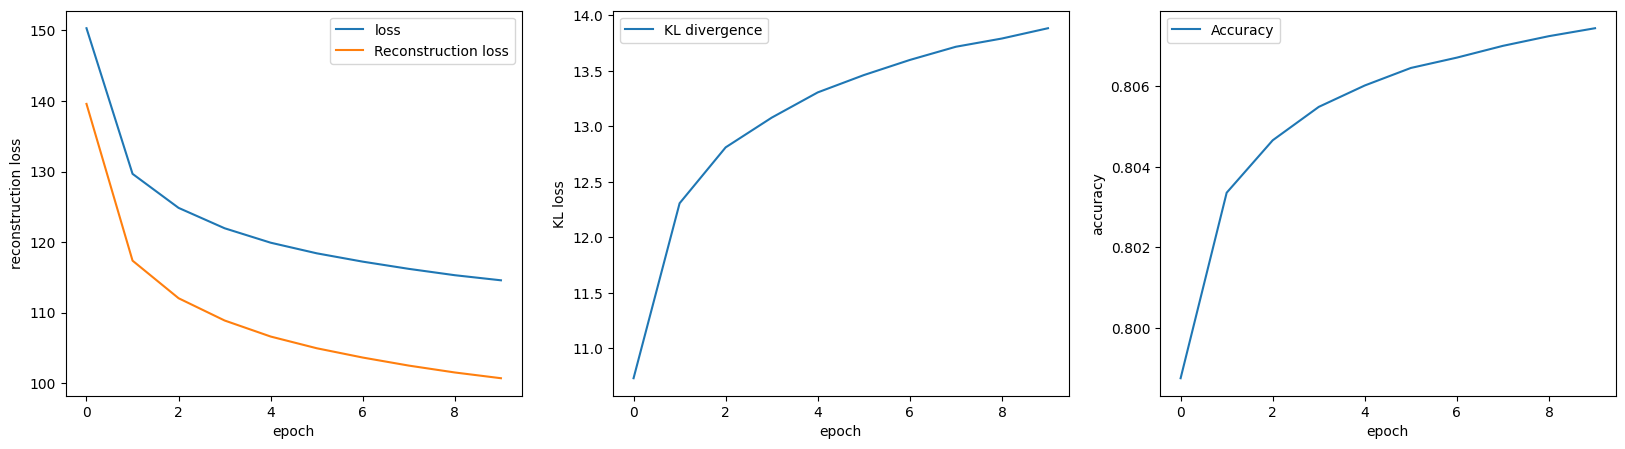

101/313 [========>.....................] - ETA: 0s

2023-01-15 20:49:12.886876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Plotting a normal 2 Dimensional Plot with  6  latent dimensions:


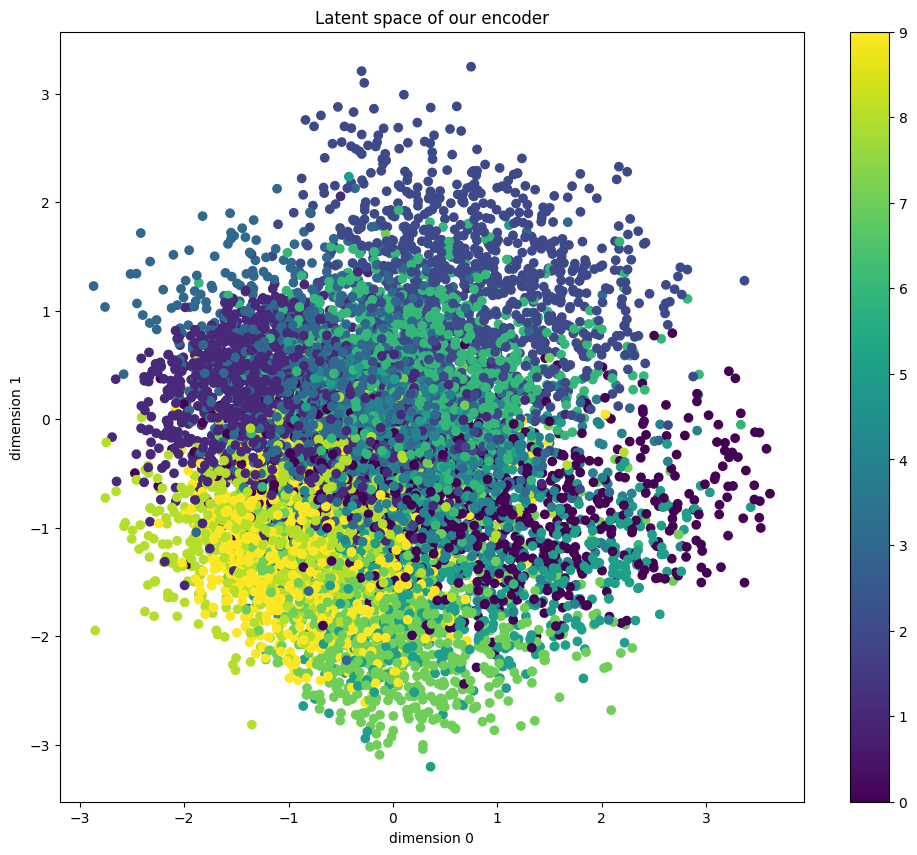

Plotting using T-SNE with 6 latent dimensions:


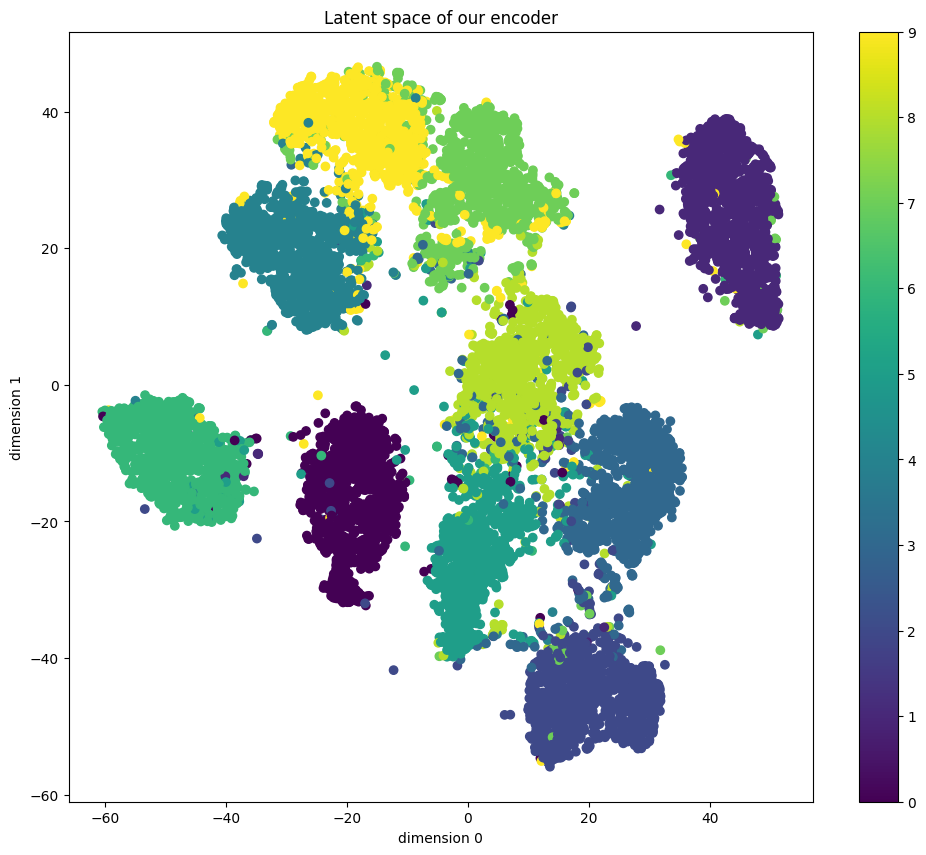

Epoch 1/10


2023-01-15 20:49:54.742499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


937/937 [==============================] - 23s 23ms/step - loss: 143.4900 - recon_loss: 129.8305 - accuracy: 0.8019 - kl_loss_metric: 13.6596
Epoch 2/10
937/937 [==============================] - 23s 24ms/step - loss: 118.0347 - recon_loss: 100.9626 - accuracy: 0.8079 - kl_loss_metric: 17.0721
Epoch 3/10
937/937 [==============================] - 22s 24ms/step - loss: 113.3713 - recon_loss: 95.7596 - accuracy: 0.8090 - kl_loss_metric: 17.6117
Epoch 4/10
937/937 [==============================] - 22s 23ms/step - loss: 110.8914 - recon_loss: 92.9461 - accuracy: 0.8097 - kl_loss_metric: 17.9452
Epoch 5/10
937/937 [==============================] - 22s 23ms/step - loss: 109.1763 - recon_loss: 91.0419 - accuracy: 0.8101 - kl_loss_metric: 18.1344
Epoch 6/10
937/937 [==============================] - 23s 24ms/step - loss: 107.9426 - recon_loss: 89.6787 - accuracy: 0.8104 - kl_loss_metric: 18.2638
Epoch 7/10
937/937 [==============================] - 23s 24ms/step - loss: 106.9713 - recon_loss

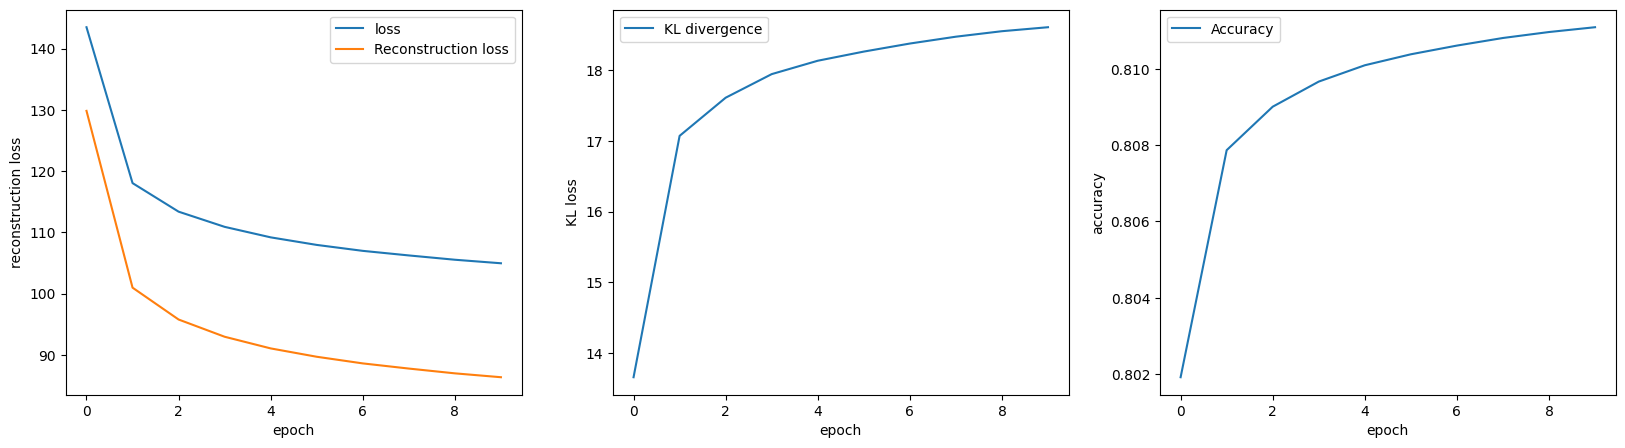

112/313 [=========>....................] - ETA: 0s

2023-01-15 20:53:33.998828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 1ms/step
Plotting a normal 2 Dimensional Plot with  10  latent dimensions:


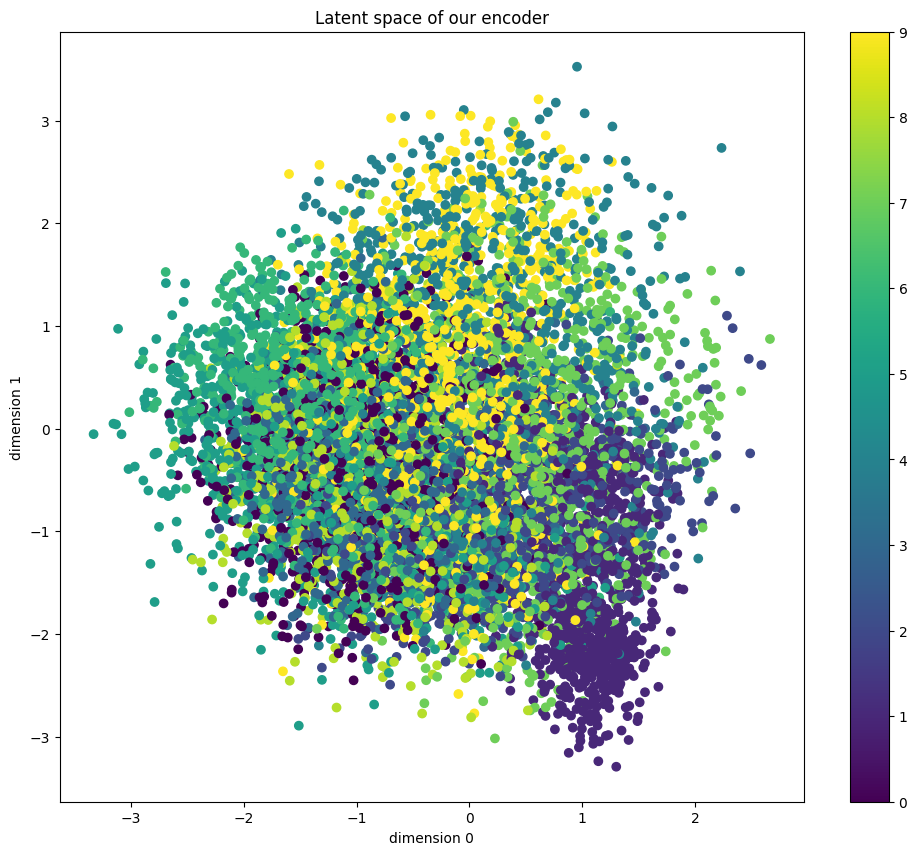

Plotting using T-SNE with 10 latent dimensions:


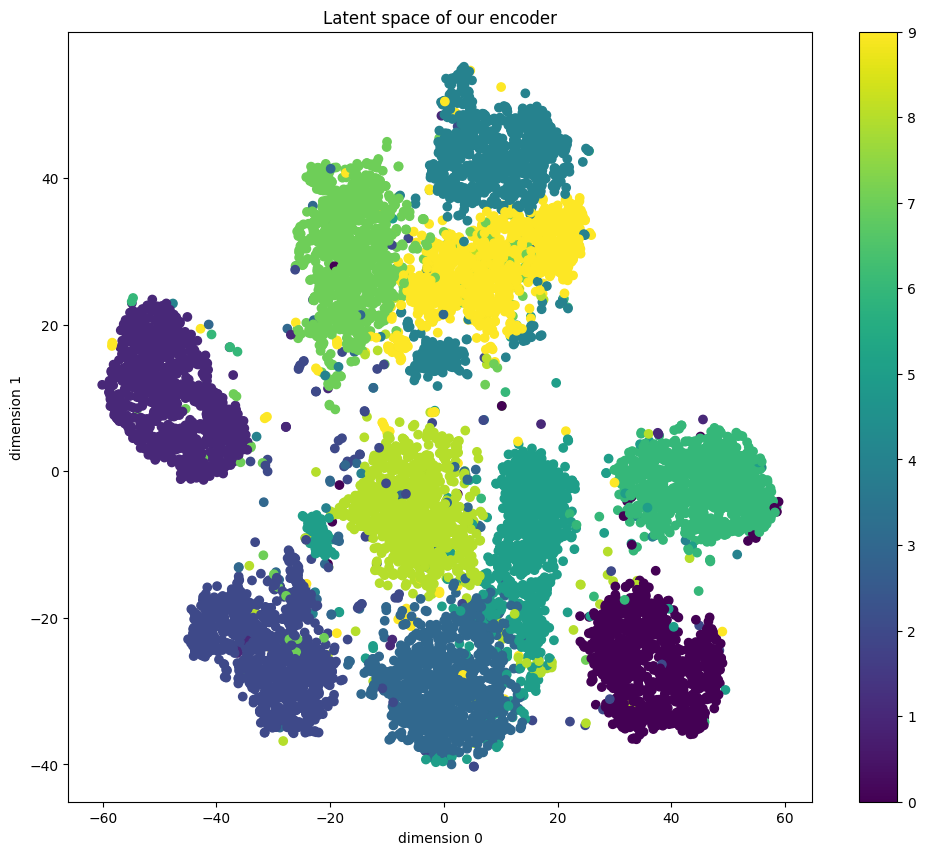

In [111]:
# Running on different dimensions:

dims = [2, 4, 6, 10]
for i in (dims):
    encoder = get_encoder(i)
    decoder = get_decoder(i)

    autoencoder = VAE(latent_dim = i, encoder = encoder, decoder = decoder)
    autoencoder.compile(tf.keras.optimizers.Nadam(),loss = recon_loss,
                        metrics = [recon_loss, 'accuracy'])


    history = autoencoder.fit(final_dataset, batch_size = 256, epochs = 10)
    history.history.keys()  
    
    plot_loss(history)

    latent_df = prep_z()
    print("Plotting a normal 2 Dimensional Plot with ",i," latent dimensions:")
    plot_latent(latent_df)

    z_arr = latent_df.values[:, :i]
    z_arr = np.array(z_arr)
    z_arr = z_arr[0:10000]
    
    z_embedded = TSNE(n_components = 2, learning_rate='auto', init = 'random', perplexity = 100).fit_transform(z_arr)

    z_embedded = pd.DataFrame(z_embedded)
    z_embedded['number'] = y_test[:10000]
    
    print("Plotting using T-SNE with", i, "latent dimensions:")
    plot_latent(z_embedded)

### 8. describe the latent space with respect to its structure. Is this what you expected from a VAE?

- 2 Dimensional Latent space:

The latent space shows a similar pattern, which we described in the lecture. One can observe, the probably most different numbers (being 0 and 1) from another being in opposite directions of dimension one. Also 4 and 8 are opposites of another, however in the dimension 0. T_SNE does not perform especially well here.

- 4 - 10. Dimensional Latent space:

From here on, the normal 2d Plots are not useful anymore, since we can not visualize it by usng two features. Therefore, T-SNE comes to the rescue.
Here we can see the core idea of using T-SNE I think. We can visualize multidimensional data by using the T-SNE algorithm and the differences in number style are still further apart than the similarities (e.g. nine and three or seven and zero).
Especially, once we are at 6 to 10 dimensions, every datapoint is almost perfectly clustered to its number.

Overall I did expect the structure of the VAE due to the explanaition in the lecture. We are creating a latent space and generate points that are as close to another as possible and thus create the generative aspect of VAEs. Its interesting, how T-SNE can still differentiate the data well. An important aspect I've realized is that a high amount of perplexity (number of nearest neighbors) is mandatory. Otherwise the data clumps up to a nicely looking ball, but not specified clusters. 

Combined with this [`video`](https://www.youtube.com/watch?v=wvsE8jm1GzE) the two dimensional T-SNE explanation makes even more sense to me.